In [1]:
import os
import os.path as op
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

en_stopwords = set((stopwords.words('english')))
es_stopwords = set((stopwords.words('spanish')))
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()
from nltk.stem import SnowballStemmer

es_stemmer = SnowballStemmer('spanish')
import math
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing

# Utils for text processing and lexicon creating 

In [2]:
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
en_stopwords = set((stopwords.words('english')))
es_stopwords = set((stopwords.words('spanish')))
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import SnowballStemmer
es_stemmer = SnowballStemmer('spanish')

import re

def to_lower(word):
    '''
    word: str, string of a single word
    This function returns the lower case of the given word
    '''
    result = word.lower()
    return result

def remove_mentions(word):
    '''
    word: str, string of a single word
    Removes mentions in tweets, they are recognized via the @ character
    '''
    result = re.sub(r"@\S+","",word)
    return result

def remove_number(word):
    '''
    word: str, string of a single word
    Removes numbers in tweets
    '''
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    '''
    word: str, string of a single word
    Removes punctuation characters of a string
    '''
    result = re.sub('[^A-Za-z]+', ' ', word)
    return result


def clean_text(raw_text):
    emoji_pat = '[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
    shrink_whitespace_reg = re.compile(r'\s{2,}')
    reg = re.compile(r'({})|[^a-zA-Z]'.format(emoji_pat)) # line a
    result = reg.sub(lambda x: ' {} '.format(x.group(1)) if x.group(1) else ' ', raw_text)
    return shrink_whitespace_reg.sub(' ', result)

def remove_en_stopwords(words):
    '''
    words: list of str, list containing the str for every word in the tweet
    stop_words: List of str, list containing all stop words for a given language
    Removes stop words in the tweet
    '''
    result = [i for i in words if i not in en_stopwords]      
    return result

def remove_es_stopwords(words):
    '''
    words: list of str, list containing the str for every word in the tweet
    stop_words: List of str, list containing all stop words for a given language
    Removes stop words in the tweet
    '''
    result = [i for i in words if i not in es_stopwords]      
    return result

def remove_stopwords(words,stopwords):
    '''
    words: list of str, list containing the str for every word in the tweet
    stop_words: List of str, list containing all stop words for a given language
    Removes stop words in the tweet
    '''
    result = [i for i in words if i not in stopwords]      
    return result

def remove_hyperlink(word):
    '''
    word: str, string of a single word
    Removes URLs in the given word
    '''
    return re.sub(r"http\S+", "", word)

def remove_whitespace(word):
    '''
    word: str, string of a single word
    Removes whitespaces from a str
    '''
    result = word.strip()
    return result

def replace_newline(word):
    '''
    word: str, string of a single word
    Removes new lines from a str
    '''
    return word.replace('\n','')

def clean_up_pipeline(sentence, keep_emojis=True):
    '''
    sentence: str, string containing the tweet
    keep_emojis: boolean, boolean that indicates if the emojis want to be kept in the tweets
    This function cleans up the tweets with previous functions
    '''
    if keep_emojis:
        cleaning_data = [remove_hyperlink,
                        replace_newline,
                        to_lower,
                        clean_text,
                        remove_mentions,
                        remove_number,
                        remove_punctuation,
                        remove_whitespace]
        for func in cleaning_data:
            
            sentence = func(sentence)
    else:
        cleaning_data = [remove_hyperlink,
                        replace_newline,
                        to_lower,
                        remove_punctuation,
                        remove_mentions,
                        remove_number,
                        remove_punctuation,
                        remove_whitespace]
        for func in cleaning_data:
            
            sentence = func(sentence) 
    return sentence


def stem_words(text,lang):
    '''
    text: list of str, list of tokens to be stemmed
    lang: str, 'en' for english, 'es' for spanish
    Returns the list of stemmed tokens according to the given language
    '''
    if lang == 'en':     
        text = [stemmer.stem(word) for word in text]
    else:
        text = [es_stemmer.stem(word) for word in text]
    return text

def create_term_index(token_docs):
    '''
    token_docs: list of lists that contain the tokens for each document
    Returns the unique token vocabulary for the given document tokens
    '''
    terms = [item for sublist in token_docs for item in sublist]
    terms = sorted(list(set(terms)))
    return terms

def get_topwords(df,number):
    '''
    df: DataFrame containing the tokens as index and the lexicon score of each token
    number: int, number of top words to be returned
    Returns a df of the top words according to the lexicon score
    '''
    df = df.sort_values(by=['score'],ascending=False)
    df = df.head(number).loc[:,['score']]
    return df

def get_dictionary(df):
    '''
    df: DataFrame containing the tokens as index and the lexicon score of each token
    Returns the lexicon in dictionary form
    '''
    df = df.sort_index()
    df = df.loc[:,['score']]
    dic = df.to_dict()
    return dic

# Functions for the processing of features for models and the training and results

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

def count_words_dictionary(list_tokens,dic):
    '''
    list_tokens: list containing the tokens for each document
    dic: dictionary, dictionary containing the lexicon
    Returns the count of tokens from the doc in the given lexicon dictionary
    '''
    counter = 0
    for token in list_tokens:
        if token in dic['score']:
            counter += 1
    return counter

def sum_words_dictionary(list_tokens,dic):
    '''
    list_tokens: list containing the tokens for each document
    dic: dictionary, dictionary containing the lexicon
    Returns the sum of tokens lexicon values from the doc in the given lexicon dictionary
    '''
    counter = 0
    for token in list_tokens:
        if token in dic['score']:
            counter = counter + dic['score'][token]
    return counter

def create_features(df,mourn_dic,nomourn_dic):
    '''
    df: DataFrame, that contains the list of tokens for each document in the text column
    mourn_dic: dictionary, mourning lexicon
    nomourn_dic: dictionary, no mourning lexicon
    
    For the given DataFrame creates the designed feature columns, returns the DataFrame
    '''
    df['NUM_TOKENS'] = df['text'].apply(lambda text: len(text))
    df['COUNT_MOURN'] = df['text'].apply(lambda text: count_words_dictionary(text,mourn_dic))
    df['SUM_MOURN'] = df['text'].apply(lambda text: sum_words_dictionary(text,mourn_dic))
    df['COUNT_NOMOURN'] = df['text'].apply(lambda text: count_words_dictionary(text,nomourn_dic))
    df['SUM_NOMOURN'] = df['text'].apply(lambda text: sum_words_dictionary(text,nomourn_dic))
    df['MOURN_PERC'] = df['COUNT_MOURN']/df['NUM_TOKENS']
    df['NOMOURN_PERC'] = df['COUNT_NOMOURN']/df['NUM_TOKENS']
    return df

def process_df(df,cols):
    '''
    df: DataFrame, that contains the features and the target variable
    cols: list, list containing the features and the target variable
    
    Returns X and y for a classifier model from the dataframe, where X are the features
    and y is the target var binarized
    '''
    df['Y']=np.where(df['tag'] == 'mourning',1,0)
    df=df.loc[:,cols]
    y = df['Y']
    X = df.drop(['Y'],axis=1).fillna(0)
    return X,y

def train_model(X,y,seed,test_prop,model):
    '''
    X: DataFrame containing the features
    y: Pandas Series containing the binarized target variable
    seed: int, seed for random states
    test_prop: float, proportion wanted for the test set
    model: str, str containing the model that is wanted. 'NB': Naive Bayes, 'LR': Logistic Regression,
    'DT': Decision Tree, 'RF': Random Forest
    
    Returns the predictions for the test set, the test set real values and the trained model
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed,test_size=test_prop)
    if model == 'NB':
        clf = GaussianNB()
    elif model == 'LR':
        clf = LogisticRegression(random_state=seed)
    elif model == 'DT':
        clf = DecisionTreeClassifier(random_state=seed)
    else:
        clf = RandomForestClassifier(random_state=seed)    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return y_pred, y_test, clf

def get_results(X,y,seed,test_prop):
    '''
    X: DataFrame containing the features
    y: Pandas Series containing the binarized target variable
    seed: int, seed for random states
    test_prop: float, proportion wanted for the test set
    
    Returns the results for each model that contains the evaluation metrics in a DataFrame for visualization
    '''
    model_list = ['NB','LR','DT','RF']
    result = pd.DataFrame(columns=['Model','Precision','Recall','F1 Score'])
    for model in model_list:
        y_pred_proba, y_test,_ = train_model(X,y,seed,test_prop,model)
        y_pred = np.where(y_pred_proba>=0.5,1,0)
        prec = precision_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        f1 = f1_score(y_test,y_pred)
        dictionary_results = {'Model': model, 'Precision': prec, 'Recall': recall,
                          'F1 Score': f1}
        
        result = result.append(dictionary_results, ignore_index=True)
    
    return result

def get_rfimportance(X,y,seed,test_prop):
    '''
    X: DataFrame containing the features
    y: Pandas Series containing the binarized target variable
    seed: int, seed for random states
    test_prop: float, proportion wanted for the test set
    
    Returns the importance of each feature for a trained random forest model    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed,test_size=test_prop)
    clf = RandomForestClassifier(random_state=seed)    
    clf.fit(X_train,y_train)
    r = permutation_importance(clf,X_test,y_test)
    return r

In [4]:
df = pd.read_csv(r'C:/Users/Jaime.Acevedo/Documents/Jd/Maestría JD/NLP/HW02/fnmourning.csv')
df

,text,tag,lang,emoticon
0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0
1,"Hoy falleció mi abuela. Y eso, sin velorio, si...",mourning,es,0
2,Muere el primer médico en activo por Covid-19 ...,mourning,es,0
3,Historia de una victoria. Historia de los últi...,mourning,es,1
4,He visto dos personas a las que les tomé cariñ...,mourning,es,0
...,...,...,...,...
24580,Ontario health-care worker who dedicated 31 ye...,no mourning,en,0
24581,"La carita triste de coronavirus, encierro, let...",no mourning,es,0
24582,@EvaR001 Me da: vergüenza JAJAJAJAJA,no mourning,es,0
24583,@History_LigaMX @atlasfc @Rayados @FCTecos @Cl...,no mourning,es,0


In [5]:
df['text'] = df['text'].apply(lambda text: clean_up_pipeline(text,keep_emojis=False)) #Here is the change for no emoticon models
df['text'] = df['text'].apply(word_tokenize)

df_en = df.loc[df['lang']=='en']
df_es = df.loc[df['lang']=='es']

df_en['text'] = df_en['text'].apply(lambda text: remove_stopwords(text,en_stopwords))
df_es['text'] = df_es['text'].apply(lambda text: remove_stopwords(text,es_stopwords))

df_en['text'] = df_en['text'].apply(lambda text: stem_words(text,'en'))
df_es['text'] = df_es['text'].apply(lambda text: stem_words(text,'es'))

data_en = list(zip(df_en.index,df_en['text']))
data_es = list(zip(df_es.index,df_es['text']))

list_tweets_processed = []
for id, text in data_en:
    list_tweets_processed.append(text)

list_tweets_processed_es = []
for id, text in data_es:
    list_tweets_processed_es.append(text)

vocabulary_en = create_term_index(list_tweets_processed)
vocabulary_es = create_term_index(list_tweets_processed_es)

vocabulary_en[-50:]

<ipython-input-5-49ce4d711625>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['text'] = df_en['text'].apply(lambda text: remove_stopwords(text,en_stopwords))
<ipython-input-5-49ce4d711625>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_es['text'] = df_es['text'].apply(lambda text: remove_stopwords(text,es_stopwords))
<ipython-input-5-49ce4d711625>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

['zedomax',
 'zeenew',
 'zeeshan',
 'zen',
 'zenithbank',
 'zenteknologist',
 'zephaniah',
 'zeppelin',
 'zero',
 'zerodhaonlin',
 'zerostudioph',
 'zetaphibeta',
 'zeusfanhous',
 'zfrmrza',
 'zhanguoc',
 'ziddi',
 'zilch',
 'zimbabw',
 'zimbabwean',
 'zimmedaarana',
 'zimmerman',
 'zimpfer',
 'zimzimzimm',
 'zinc',
 'zip',
 'zippi',
 'zippyriff',
 'zmacewen',
 'zoe',
 'zoila',
 'zombi',
 'zombieapocalyps',
 'zone',
 'zoo',
 'zooarcheolog',
 'zoom',
 'zoomchat',
 'zoomconferenc',
 'zphib',
 'zquad',
 'zshq',
 'zucker',
 'zucotto',
 'zuma',
 'zuniga',
 'zuraida',
 'zurich',
 'zwia',
 'zyelri',
 'zzzzzzzzzz']

It can be noted that emticons no longer appear in the created vocabulary.

In [6]:
def get_nb_results(list_tweets,df,vocabulary):
    '''
    list_tweets: list of lists containing the tokens for each document
    df: DataFrame containing the the text for each document and the tag
    vocabulary: list, vocabulary of tokens
    
    Function that does the pipeline for the Naive Bayes results, it takes the DataFrame separates into
    mourning and no mourning tweets. Gets the vocabulary for both tags, and finally scores the nb value
    for each token in each class.
    
    Returns the mourn NB tokens and values in a DataFrame, the not mourn NB tokens and values in a DataFrame,
    and the full vocabulary with the NB values for both classes and the tag column where the class is decided:
    if MournNB > NoMournNB then mourning else no mourning
    '''
    mlb = MultiLabelBinarizer()
    mlb.fit(list_tweets)

    df_en_m = df.loc[df['tag']=='mourning']
    df_en_nom = df.loc[df['tag']=='no mourning']

    data_en_mourn = list(zip(df_en_m.index,df_en_m['text']))

    list_tweets_processed_mourn = []
    for id, text in data_en_mourn:
        list_tweets_processed_mourn.append(text)

    X_en_mourn = mlb.transform(list_tweets_processed_mourn)
    english_mourn = pd.DataFrame(X_en_mourn, columns = mlb.classes_).T

    data_en_nomourn = list(zip(df_en_nom.index,df_en_nom['text']))

    list_tweets_processed_nomourn = []
    for id, text in data_en_nomourn:
        list_tweets_processed_nomourn.append(text)

    X_en_nomourn = mlb.transform(list_tweets_processed_nomourn)
    english_nomourn = pd.DataFrame(X_en_nomourn, columns = mlb.classes_).T

    pmourn = np.log(sum(df['tag']=='mourning')/len(df['tag']))
    pnomourn = np.log(sum(df['tag']=='no mourning')/len(df['tag']))

    vocabulary_en_mourn = create_term_index(list_tweets_processed_mourn)
    vocabulary_en_nomourn = create_term_index(list_tweets_processed_nomourn)

    wic_en_mourn = (english_mourn.sum(axis=1)+1)/(len(vocabulary_en_mourn)+len(vocabulary))
    wic_en_nomourn = (english_nomourn.sum(axis=1)+1)/(len(vocabulary_en_nomourn)+len(vocabulary))

    nb_en = pd.DataFrame(dict(wic_en_mourn = wic_en_mourn, wic_en_nomourn = wic_en_nomourn)).reset_index()
    nb_en['wic_en_mourn'] = np.log(nb_en['wic_en_mourn']) 
    nb_en['wic_en_nomourn'] = np.log(nb_en['wic_en_nomourn'])
    nb_en['nb_mourn'] = pmourn + nb_en['wic_en_mourn']
    nb_en['nb_nomourn'] = pnomourn + nb_en['wic_en_nomourn']

    nb_en['nb_class'] = np.where(nb_en['nb_mourn']>nb_en['nb_nomourn'],'mourning','no mourning')

    mourn_nb = nb_en[nb_en['nb_class'] == 'mourning'].loc[:,['index','nb_mourn']].sort_values(by=['nb_mourn'],ascending=False).set_index('index')
    nomourn_nb = nb_en[nb_en['nb_class'] == 'no mourning'].loc[:,['index','nb_nomourn']].sort_values(by=['nb_nomourn'],ascending=False).set_index('index')
    return mourn_nb, nomourn_nb, nb_en

In [7]:
mourn_nb_en, nomourn_nb_en, nb_en = get_nb_results(list_tweets_processed,df_en,vocabulary_en)
mourn_nb_es, nomourn_nb_es, nb_es = get_nb_results(list_tweets_processed_es,df_es,vocabulary_es)

mourn_nb_en

,nb_mourn
index,
rip,-3.636180
famili,-4.183969
die,-4.279999
peac,-4.320444
condol,-4.349154
...,...
iconiclasvega,-10.370177
icnurs,-10.370177
icmr,-10.370177


This next blocks transform the lexicon to a scaled value between 0 and 1

In [8]:
scaler = preprocessing.MinMaxScaler()
es_scaler = preprocessing.MinMaxScaler()

mourn_nb_en['score'] = scaler.fit_transform(mourn_nb_en)
nomourn_nb_en['score'] = scaler.transform(nomourn_nb_en)

mourn_nb_es['score'] = es_scaler.fit_transform(mourn_nb_es)
nomourn_nb_es['score'] = es_scaler.transform(nomourn_nb_es)

mourn_nb_en

,nb_mourn,score
index,,
rip,-3.636180,1.000000
famili,-4.183969,0.918653
die,-4.279999,0.904393
peac,-4.320444,0.898387
condol,-4.349154,0.894123
...,...,...
iconiclasvega,-10.370177,0.000000
icnurs,-10.370177,0.000000
icmr,-10.370177,0.000000


# Top 25 English mourn terms 

<Figure size 432x288 with 0 Axes>

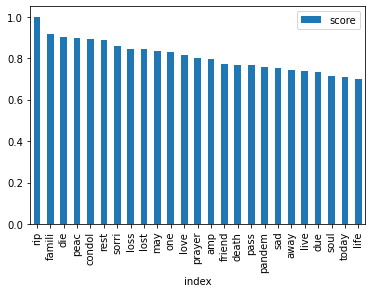

In [9]:
plt.figure()
words = get_topwords(mourn_nb_en,25)
words.plot(kind='bar')
plt.show()

# Top 25 spanish mourn terms

<Figure size 432x288 with 0 Axes>

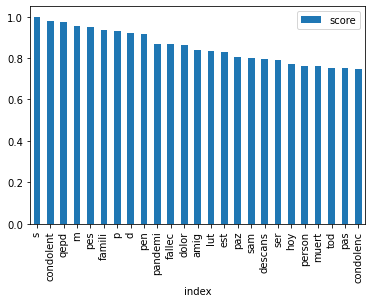

In [10]:
plt.figure()
words = get_topwords(mourn_nb_es,25)
words.plot(kind='bar')
plt.show()

In general we can see that the top 25 terms remain similar, with the only difference being the emojis that previously featured as some of the top words for both languages like the heart or pray emoji are no longer there.

Creating lexicon dictionaries for mourning and not mourning for both languages

In [11]:
dict_mourn_en = get_dictionary(mourn_nb_en)
dict_nomourn_en = get_dictionary(nomourn_nb_en)
dict_mourn_es = get_dictionary(mourn_nb_es)
dict_nomourn_es = get_dictionary(nomourn_nb_es)

dict_mourn_en

{'score': {'aaaaaaaand': 0.0,
  'aaaaw': 0.0,
  'aal': 0.0,
  'aaliyah': 0.06021165601161149,
  'aan': 0.0,
  'aap': 0.0,
  'aapko': 0.0,
  'aaron': 0.0,
  'aatmanirbharbharatmor': 0.13606937132434216,
  'abakaliki': 0.0,
  'abatcha': 0.0,
  'abbot': 0.0,
  'abd': 0.0,
  'abdel': 0.0,
  'abdelfattah': 0.16314416183443115,
  'abdelmadjid': 0.0,
  'abdiqani': 0.0,
  'abdrabbo': 0.16314416183443115,
  'abdul': 0.06021165601161149,
  'abdullahi': 0.0,
  'abe': 0.10293250582281965,
  'abia': 0.0,
  'abid': 0.0,
  'abject': 0.0,
  'abl': 0.4448668887928009,
  'aboard': 0.0,
  'abod': 0.0,
  'abscbn': 0.0,
  'abscbnfranchis': 0.0,
  'absenc': 0.06021165601161149,
  'absenteeadam': 0.0,
  'absolut': 0.46235769499320445,
  'abteach': 0.0,
  'abu': 0.0,
  'abudhabi': 0.0,
  'abuelita': 0.0,
  'abuelito': 0.0,
  'aburizalbakri': 0.0,
  'abuti': 0.0,
  'academ': 0.16314416183443115,
  'academia': 0.06021165601161149,
  'acanadianinusa': 0.0,
  'acc': 0.06021165601161149,
  'acccgovau': 0.0,
  'acc

In [12]:
dict_mourn_es

{'score': {'aaaaa': 0.0,
  'aalb': 0.0,
  'aalimentari': 0.0,
  'aaronri': 0.0,
  'aatanaci': 0.0,
  'ab': 0.06144164789582529,
  'aba': 0.10503519083715385,
  'abad': 0.13884896971948946,
  'abaj': 0.18983586914878958,
  'abal': 0.0,
  'abandon': 0.29487105998594343,
  'abarrot': 0.06144164789582529,
  'abasatec': 0.0,
  'abc': 0.415329764069055,
  'abcradiomx': 0.0,
  'abdo': 0.0,
  'abdominal': 0.10503519083715385,
  'abej': 0.0,
  'aberraci': 0.0,
  'abiert': 0.3151055725114613,
  'abiertasqepd': 0.0,
  'abinad': 0.0,
  'abisp': 0.0,
  'able': 0.10503519083715385,
  'ables': 0.0,
  'abn': 0.0,
  'abo': 0.0,
  'abogadoantoniov': 0.0,
  'abolicion': 0.0,
  'abolishic': 0.0,
  'abon': 0.0,
  'abra': 0.06144164789582529,
  'abrac': 0.06144164789582529,
  'abrahamendiet': 0.06144164789582529,
  'abran': 0.06144164789582529,
  'abraz': 0.7370117975648796,
  'abrazal': 0.0,
  'abrazosvirtual': 0.0,
  'abrelosoj': 0.06144164789582529,
  'abreu': 0.10503519083715385,
  'abrham': 0.0,
  'abr

# Classifier without emoticons

Proposed features: Number of tokens, number of mourning tokens, number of not mourning tokens, sum of mourning lexicon token values, sum of not mourning lexicon token values, mourning token percentage and not mourning token percentage. Additionally the tag variable is set to 1 as mourning and 0 as not mourning

In [13]:
#Here we create the features for the datapoints
df_en = create_features(df_en,dict_mourn_en,dict_mourn_en)
df_es = create_features(df_es,dict_mourn_es,dict_mourn_es)

cols = ['NUM_TOKENS','COUNT_MOURN','SUM_MOURN','COUNT_NOMOURN','SUM_NOMOURN','MOURN_PERC','NOMOURN_PERC','Y']

#Here we create the X and y objects for the models
X, y = process_df(df_en,cols)
X_es, y_es = process_df(df_es,cols)

#Here we compare the results for each model on each language
result = get_results(X,y,23,0.25)
result_es = get_results(X_es,y_es,23,0.25)

<ipython-input-3-998d1b7c312d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NUM_TOKENS'] = df['text'].apply(lambda text: len(text))
<ipython-input-3-998d1b7c312d>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['COUNT_MOURN'] = df['text'].apply(lambda text: count_words_dictionary(text,mourn_dic))
<ipython-input-3-998d1b7c312d>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

English results with emoticons

In [14]:
result

,Model,Precision,Recall,F1 Score
0,NB,0.883167,0.871775,0.877434
1,LR,0.908807,0.884674,0.896578
2,DT,0.865559,0.869499,0.867525
3,RF,0.875371,0.895296,0.885221


Spanish results with emoticons

In [15]:
result_es

,Model,Precision,Recall,F1 Score
0,NB,0.861342,0.838830,0.849937
1,LR,0.889311,0.874922,0.882058
2,DT,0.850525,0.856876,0.853689
3,RF,0.868668,0.864343,0.866500


It can be noted that the same models work better without emoticons, the Logistic Regression its stilll the best model for both languages, followed by the Random Forest.

When comparing the results to the previously obtained with emoticon we can see that most cases lose around 0.002 in the F1 score with the omission of them. This highlights that the emoticones are providing usefull information for the mourning tweet classifier. Therefore the recommendation would be to keep them.

Feature importance for the Logistic Regression

In [16]:
_, _, lr = train_model(X,y,23,0.25,'LR')
lr_coef = lr.coef_
lr_int = lr.intercept_

print('English model feature importance: ',lr_coef,lr_int)

_, _, lr = train_model(X_es,y_es,23,0.25,'LR')
lr_coef = lr.coef_
lr_int = lr.intercept_

print('Spanish model feature importance: ',lr_coef,lr_int)


English model feature importance:  [[-0.12707453  0.38459171 -0.24052616  0.38459171 -0.24052616  3.09601308
   3.09601308]] [-3.81763398]
Spanish model feature importance:  [[-0.15578617  0.43903907 -0.3481138   0.43903907 -0.3481138   2.89950264
   2.89950264]] [-3.99683867]


In [17]:
cols

['NUM_TOKENS',
 'COUNT_MOURN',
 'SUM_MOURN',
 'COUNT_NOMOURN',
 'SUM_NOMOURN',
 'MOURN_PERC',
 'NOMOURN_PERC',
 'Y']

The designed feature importance for the logistic regression remain very similar among the models with and without emoticons. Higlighting again the information given by the percentages variables.

Feature importance Random Forest

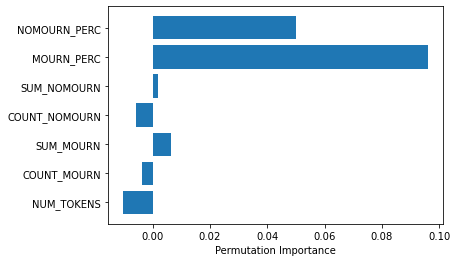

In [18]:
perm_importance = get_rfimportance(X,y,23,0.25)
#sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(cols[:-1], perm_importance.importances_mean)
plt.xlabel("Permutation Importance")
plt.show()

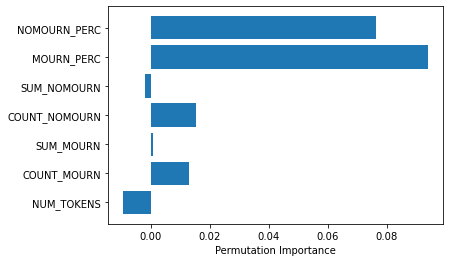

In [19]:
perm_importance = get_rfimportance(X_es,y_es,23,0.25)
#sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(cols[:-1], perm_importance.importances_mean)
plt.xlabel("Permutation Importance")
plt.show()

With the Random Forest the most important variables remain similar as well. This can be proofed by the results of the model remain very similar with and without emoticons.

# Final Conclusions

In general terms we can see that the logistic model remains the best model out of the 4 compared, additionally we can see that the results improve for the mourning classifier when we keep the emoticons in the tweet as terms. Finally we argue that the designed variables are proven to be effective for the task, obtaining a F1 Score slightly over 0.89 in the english classifier and slightly below it for the spanish classifier.

As said before, it makes sense that the english classifier works better, this is due because the normalization techniques are more advanced in development for english and therefore the resulting lexicon is better.